# Analyzing Predictors of Coffee Shop Daily Revenue using Multiple Linear Regression

Robert Hall

STA 4713, Dr. Dae Young Ham

December 2, 2025

### Contents

1) Importing Data
2) Building Multiple Linear Regression Model
3) Checking Normality Assumptions using Q-Q Plot
4) Checking for Heteroskedasticity using Breusch-Pagan
5) Testing Whether Omitting Non-Significant Features Greatly Affects Model Accuracy
6) Simplified Model
7) Conclusion (TLDR)
8) Sources and Subnotes

### 1. Importing Data

In [1]:
import pandas as pd
coffee = pd.read_csv("coffee_shop_revenue.csv")
coffee.head()

,Number_of_Customers_Per_Day,Average_Order_Value,Operating_Hours_Per_Day,Number_of_Employees,Marketing_Spend_Per_Day,Location_Foot_Traffic,Daily_Revenue
0,152,6.74,14,4,106.62,97,1547.81
1,485,4.50,12,8,57.83,744,2084.68
2,398,9.09,6,6,91.76,636,3118.39
3,320,8.48,17,4,462.63,770,2912.20
4,156,7.44,17,2,412.52,232,1663.42


### 2. Building Multiple Linear Regression Model
For predicting  `Daily_Revenue` based on the six predictors given

In [2]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# MULTIPLE LINEAR REGRESSION
revenue_model = ols(
    'Daily_Revenue ~ Number_of_Customers_Per_Day + Average_Order_Value + Operating_Hours_Per_Day + \
     Number_of_Employees + Marketing_Spend_Per_Day + Location_Foot_Traffic',
    data=coffee
).fit()
print(revenue_model.summary())

                            OLS Regression Results                            
Dep. Variable:          Daily_Revenue   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     2732.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:58:22   Log-Likelihood:                -14383.
No. Observations:                2000   AIC:                         2.878e+04
Df Residuals:                    1993   BIC:                         2.882e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

1. Daily loss, unrealistic nonetheless, would be approximately $1,517.93 assuming all predictors were zero. 

2. On average, a single-customer increase per day would cause a $5.57 increase in daily revenue (P>|t| < 0.000).

3. On average, a dollar-increase per day in average amount paid by customers would cause a $243.28 increase in daily revenue (P>|t| < 0.000).

4. On average a dollar-increase per day in marketing spending by the shop would cause a $1.55 incraese in daily revenue (P>|t| < 0.000).

5. The other effects factored into the model -- the shop's operating hours per day, the number of shop employees, and the number of people passing by the shop per hour -- are not significant at the 5% level. 

6. Approximately 89.1% of the variation in daily revenue can be explained by this model.

### 3. Checking Normality Assumption using QQ Plot

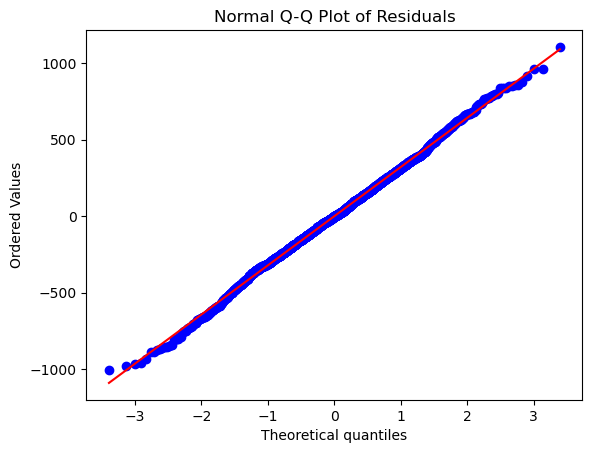

In [3]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# CHECKING NORMALITY ASSUMPTIONS
stats.probplot(revenue_model.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot of Residuals")
plt.show()

The relationship between ordered and theoretical values appears tightly linear, indicating strong normality.

### 4. Checking for Heteroskedasticity using Breusch-Pagan

Testing the following hypotheses:
* `H_0`: `Var(epsilon_i) = sigma^2`               
    (variance is constant -- homoskedasticity)
* `H_a`: `Var(epsilon_i) = sigma^2 * h(X_i)`      
    (variance is dependent on the regressors -- heteroskedasticity)

Where `h(X_i)` represents an unknown variance function unique to observation `i`.

In [4]:
import pandas as pd
from statsmodels.stats.diagnostic import het_breuschpagan

# CHECK FOR HETEROSKEDASTICITY USING BREUSCH-PAGAN
bp_test = het_breuschpagan(revenue_model.resid, revenue_model.model.exog)
bp_table = pd.DataFrame({
    "Statistic": ["LM Test", "F Test"],
    "Test Statistic": [bp_test[0], bp_test[2]],
    "p-value": [bp_test[1], bp_test[3]]
})
bp_table

,Statistic,Test Statistic,p-value
0,LM Test,4.349572,0.629482
1,F Test,0.723966,0.630309


Fail to reject `H_0`; the homoskedasticity assumption holds.

### 5. Testing Whether Omitting Non-Significant Features Greatly Affects Model Accuracy

In [5]:
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

# DEFINE FEATURES AND VARIABLES TARGETED FOR OMISSION
target = "Daily_Revenue"
all_features = [
    "Number_of_Customers_Per_Day",
    "Average_Order_Value",
    "Marketing_Spend_Per_Day",
    "Operating_Hours_Per_Day",
    "Number_of_Employees",
    "Location_Foot_Traffic"
]
combo_candidates = [
    "Operating_Hours_Per_Day",
    "Number_of_Employees",
    "Location_Foot_Traffic"
]

# FULL MODEL ANALYSIS
y = coffee[target].values
y_hat_full = revenue_model.fittedvalues.values
rmse_full = np.sqrt(mean_squared_error(y, y_hat_full))      # baseline metrics
mse_full = mean_squared_error(y, y_hat_full)

X_full = coffee[all_features].values
kf = KFold(n_splits=5, shuffle=True, random_state=42)       # 5-fold cross validation model
lr = LinearRegression()                                     # linear regression model

cv_scores_full = cross_val_score(lr, X_full, y,             # 5-fold CV scoring
                                 scoring="neg_root_mean_squared_error", 
                                 cv=kf)
cv_rmse_full_mean = -cv_scores_full.mean()
cv_rmse_full_std = cv_scores_full.std()

# ESTABLISH COMBINATIONS OF OMITTED VARIABLES
drop_combinations = []
for r in range(1, len(combo_candidates) + 1):
    drop_combinations.extend(itertools.combinations(combo_candidates, r))

# APPEND RESULTS TO LIST FOR FURTHER TABULATION
results = []
results.append({
    "dropped_variables": "None (full model)",
    "n_predictors": len(all_features),
    "train_RMSE": rmse_full,
    "train_MSE": mse_full,
    "cv_RMSE_mean": cv_rmse_full_mean,
    "cv_RMSE_std": cv_rmse_full_std,
    "AIC": revenue_model.aic,
    "BIC": revenue_model.bic,
    "adj_R2": revenue_model.rsquared_adj,
    "F_stat_nested": np.nan,
    "F_pvalue_nested": np.nan,
    "df_diff_nested": np.nan
})

# ITERATIVELY EVALUATE LIKEWISE RESULTS OF FULL MODEL 
# MINUS INSIGNIFICANT FEATURES (AND COMBINATIONS THEREOF)
for combo in drop_combinations:
    reduced_features = [f for f in all_features if f not in combo]
    dropped_label = ", ".join(combo)
    formula_reduced = f"{target} ~ " + " + ".join(reduced_features)
    model_reduced = smf.ols(formula=formula_reduced, data=coffee).fit()
    y_hat_red = model_reduced.fittedvalues.values
    rmse_red = np.sqrt(mean_squared_error(y, y_hat_red))
    mse_red = mean_squared_error(y, y_hat_red)
    X_red = coffee[reduced_features].values
    cv_scores_red = cross_val_score(lr, X_red, y, scoring="neg_root_mean_squared_error", cv=kf)
    cv_rmse_red_mean = -cv_scores_red.mean()
    cv_rmse_red_std = cv_scores_red.std()
    F_stat, F_pvalue, df_diff = revenue_model.compare_f_test(model_reduced)
    results.append({
        "dropped_variables": dropped_label,
        "n_predictors": len(reduced_features),
        "train_RMSE": rmse_red,
        "train_MSE": mse_red,
        "cv_RMSE_mean": cv_rmse_red_mean,
        "cv_RMSE_std": cv_rmse_red_std,
        "AIC": model_reduced.aic,
        "BIC": model_reduced.bic,
        "adj_R2": model_reduced.rsquared_adj,
        "F_stat_nested": F_stat,
        "F_pvalue_nested": F_pvalue,
        "df_diff_nested": df_diff
    })

# COMPILE RESULTS TO DATAFRAME FOR ANALYSIS
results_df = pd.DataFrame(results)
results_df["ID"] = range(len(results_df))
results_df

,dropped_variables,n_predictors,train_RMSE,train_MSE,cv_RMSE_mean,cv_RMSE_std,AIC,BIC,adj_R2,F_stat_nested,F_pvalue_nested,df_diff_nested,ID
0,None (full model),6,321.356297,103269.869734,322.129942,8.630617,28779.956003,28819.162321,0.891253,NaN,NaN,NaN,0
1,Operating_Hours_Per_Day,5,321.357300,103270.514568,322.102010,8.655927,28777.968492,28811.573906,0.891307,0.012445,0.911187,1.0,1
2,Number_of_Employees,5,321.473221,103345.031665,322.007492,8.355758,28779.411115,28813.016530,0.891229,1.450546,0.228583,1.0,2
3,Location_Foot_Traffic,5,321.423457,103313.038500,322.117236,8.442274,28778.791867,28812.397281,0.891262,0.833112,0.361485,1.0,3
4,"Operating_Hours_Per_Day, Number_of_Employees",4,321.473677,103345.324859,321.978831,8.377822,28777.416789,28805.421301,0.891283,0.728102,0.482953,2.0,4
5,"Operating_Hours_Per_Day, Location_Foot_Traffic",4,321.424247,103313.546723,322.087662,8.469068,28776.801705,28804.806217,0.891316,0.421460,0.656147,2.0,5
6,"Number_of_Employees, Location_Foot_Traffic",4,321.548007,103393.120705,322.001489,8.138238,28778.341549,28806.346061,0.891233,1.189307,0.304648,2.0,6
7,"Operating_Hours_Per_Day, Number_of_Employees, ...",3,321.548305,103393.312150,321.971443,8.161881,28776.345252,28798.748862,0.891287,0.794103,0.497091,3.0,7


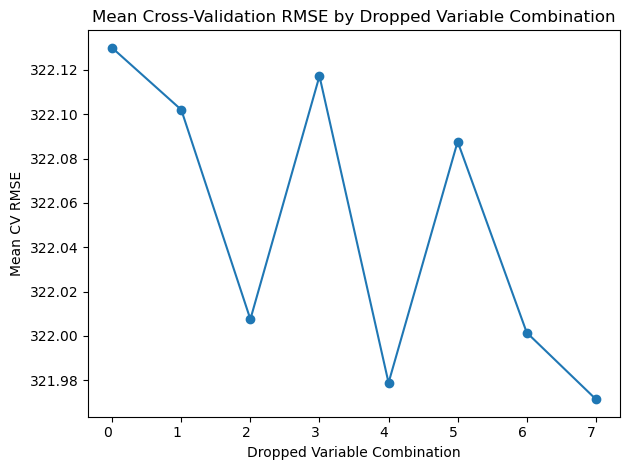

In [6]:
# VISUALIZE MEAN CV RMSE AGAINST EACH OMISSION COMBINATION
plt.figure()
plt.plot(results_df["ID"], results_df["cv_RMSE_mean"], marker='o')
plt.xticks(rotation=0, ha="right")
plt.xlabel("Dropped Variable Combination")
plt.ylabel("Mean CV RMSE")
plt.title("Mean Cross-Validation RMSE by Dropped Variable Combination")
plt.tight_layout()
plt.show()

Answers question: "Which model trains best on new data?"

The lower the Mean CV RMSE, the better the model predicts new data points.

The lowest Mean CV RMSE occurs when the following combinations are dropped from model consideration:
* 4 = {Operating_Hours_Per_Day, Number_of_Employees} 
* 7 = {Operating_Hours_Per_Day, Number_of_Employees, Location_Foot_Traffic}

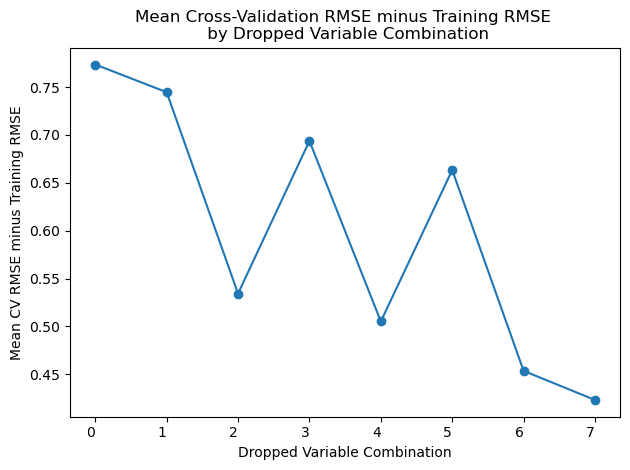

In [7]:
# VISUALIZE MEAN CV RMSE AGAINST EACH OMISSION COMBINATION
plt.figure()
plt.plot(results_df["ID"], results_df["cv_RMSE_mean"] - results_df["train_RMSE"], marker='o')
plt.xticks(rotation=0, ha="right")
plt.xlabel("Dropped Variable Combination")
plt.ylabel("Mean CV RMSE minus Training RMSE")
plt.title("Mean Cross-Validation RMSE minus Training RMSE \n by Dropped Variable Combination")
plt.tight_layout()
plt.show()

Answers question: "Is the gap between Mean CV RMSE and training RMSE small? I.e. does the model overfit?"

The lower the gap between Mean CV RMSE and training RMSE, the healthier the model fit is to generalize on new data.

The lowest gaps occur when the following combinations are dropped from model consideration:
* 6 = {Number_of_Employees, Location_Foot_Traffic} 
* 7 = {Operating_Hours_Per_Day, Number_of_Employees, Location_Foot_Traffic}

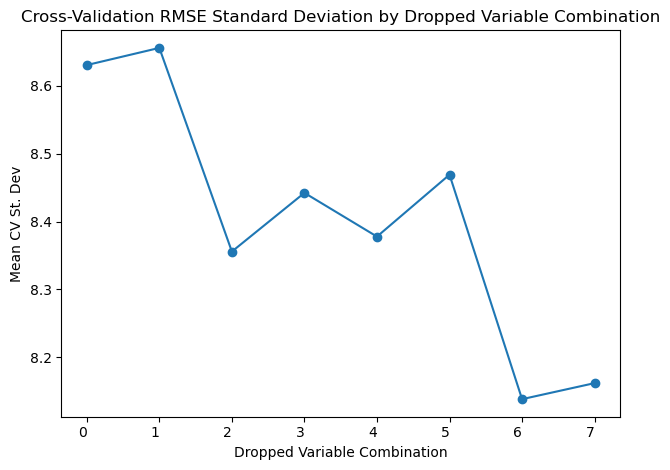

In [8]:
# VISUALIZE CV RMSE STANDARD DEVIATION AGAINST EACH OMISSION COMBINATION
plt.figure()
plt.plot(results_df["ID"], results_df["cv_RMSE_std"], marker='o')
plt.xticks(rotation=0, ha="right")
plt.xlabel("Dropped Variable Combination")
plt.ylabel("Mean CV St. Dev")
plt.title("Cross-Validation RMSE Standard Deviation by Dropped Variable Combination")
plt.tight_layout()
plt.show()

Answers question: "Is the model stable across samples?"

The lower the CV RMSE standard deviation, the more reliable the fit of the model.

The lowest gaps occur when the following combinations are dropped from model consideration:
* 6 = {Number_of_Employees, Location_Foot_Traffic} 
* 7 = {Operating_Hours_Per_Day, Number_of_Employees, Location_Foot_Traffic}

Looking at only training RMSE, ceteris paribus -- for simplicity, dropping insignificant features would leave a marginal scar on the training MSE, but if simplification is not needed, no variables should be dropped.

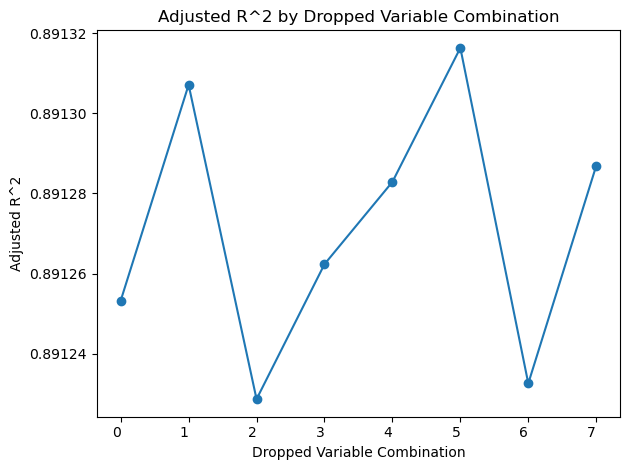

In [9]:
# VISUALIZE ADJ-R^2 AGAINST EACH OMISSION COMBINATION
plt.figure()
plt.plot(results_df["ID"], results_df["adj_R2"], marker='o')
plt.xticks(rotation=0, ha="right")
plt.xlabel("Dropped Variable Combination")
plt.ylabel("Adjusted R^2")
plt.title("Adjusted R^2 by Dropped Variable Combination")
plt.tight_layout()
plt.show()

Answers question: "What percentage of variation does the model explain after penalizing complexity?"

The higher the Adj-R^2, the better the model explains the variation in daily revenue with respect to the variation in the predictor features.

The highest Adj-R^2 scores occur when the following combinations are dropped from model consideration:
* 5 = {Operating_Hours_Per_Day, Location_Foot_Traffic}
* 1 = No features omitted 
* 7 = {Operating_Hours_Per_Day, Number_of_Employees, Location_Foot_Traffic}

### 6. Simplified Model

It appears that dropping all three of the insignificant predictors leads to better CV predictions, better generalization, and more consistency in results, all while maintaining a relatively explanable model using the significant features (R^2 = 0.89128). Therefore, the model will be whittled down to only the significant features from the summary table.

In [10]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# MULTIPLE LINEAR REGRESSION
revenue_model = ols(
    'Daily_Revenue ~ Number_of_Customers_Per_Day + Average_Order_Value + Marketing_Spend_Per_Day',
    data=coffee
).fit()
print(revenue_model.summary())

                            OLS Regression Results                            
Dep. Variable:          Daily_Revenue   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     5464.
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:58:23   Log-Likelihood:                -14384.
No. Observations:                2000   AIC:                         2.878e+04
Df Residuals:                    1996   BIC:                         2.880e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

### 7. Conclusion (TLDR)

The best predictors of daily revenue are, in descending order:
* How many customers the coffee shop is getting per day
* How much, on average, people are paying for their order ($$)
* The shop's daily marketing and promotions spending

An increase in 1...
* customer brings an average of **$5.57** in daily revenue
* dollar on the average order payment ($$) brings in an average **$243.30** in daily revenue
* dollar of marking and promotions spending brings an average of **$1.55** in daily revenue

### 8. Sources and Subnotes

Data source: https://www.kaggle.com/datasets/himelsarder/coffee-shop-daily-revenue-prediction-dataset?utm_source=chatgpt.com

Project completed for my university course in Applied Regression Analysis (STA 4713) at the University of Texas at San Antonio, under the guidance of Dr. Dae Young Ham.

This project was completed for a grade in the course.